# 00_clean_and_explore_macro_data.ipynb

This notebook is for initial inspection and cleaning of Layer 1 Core Macro data across the US, Euro Area, and China.

## Sections:
1. Load Raw Macro Data
2. Visualize Missingness
3. Clean and Interpolate (per region)
4. Export Cleaned CSVs
5. Optional: Summary Stats and First Diagnostics

In [11]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

US_RAW_PATH = "../data/Layer 1 - Core Macro/us/raw"

### US DATA

#### Exploration

In [12]:
# List headers of all US macroeconomic CSVs
us_headers = {}

for fname in sorted(os.listdir(US_RAW_PATH)):
    if fname.endswith(".csv"):
        path = os.path.join(US_RAW_PATH, fname)
        try:
            df = pd.read_csv(path, nrows=1)
            us_headers[fname] = list(df.columns)
        except Exception as e:
            us_headers[fname] = f"Error: {e}"

# Show them
for file, cols in us_headers.items():
    print(f"{file}: {cols}")

cpi_all_items.csv: ['date', 'cpi_all_items']
fed_funds_rate.csv: ['date', 'fed_funds_rate']
gdp_quarterly.csv: ['date', 'gdp_quarterly']
initial_jobless_claims.csv: ['date', 'initial_jobless_claims']
labor_force_participation.csv: ['date', 'labor_force_participation']
pce_consumption.csv: ['date', 'pce_consumption']
unemployment_rate.csv: ['date', 'unemployment_rate']
yield_10y.csv: ['date', 'yield_10y']
yield_2y.csv: ['date', 'yield_2y']
yield_curve_10y_2y.csv: ['date', 'yield_curve_10y_2y']


In [13]:
def load_us_macro_data():
    data_frames = []

    for fname in sorted(os.listdir(US_RAW_PATH)):
        if fname.endswith(".csv"):
            path = os.path.join(US_RAW_PATH, fname)
            df = pd.read_csv(path)

            # Guess date column
            date_col = next((c for c in df.columns if "date" in c.lower()), df.columns[0])
            df[date_col] = pd.to_datetime(df[date_col])
            df.set_index(date_col, inplace=True)
            df.sort_index(inplace=True)

            # Use filename as column name
            value_col = df.columns[0]
            col_name = os.path.splitext(fname)[0]
            df.rename(columns={value_col: col_name}, inplace=True)

            data_frames.append(df)

    if data_frames:
        return pd.concat(data_frames, axis=1)
    return pd.DataFrame()

us_df = load_us_macro_data()


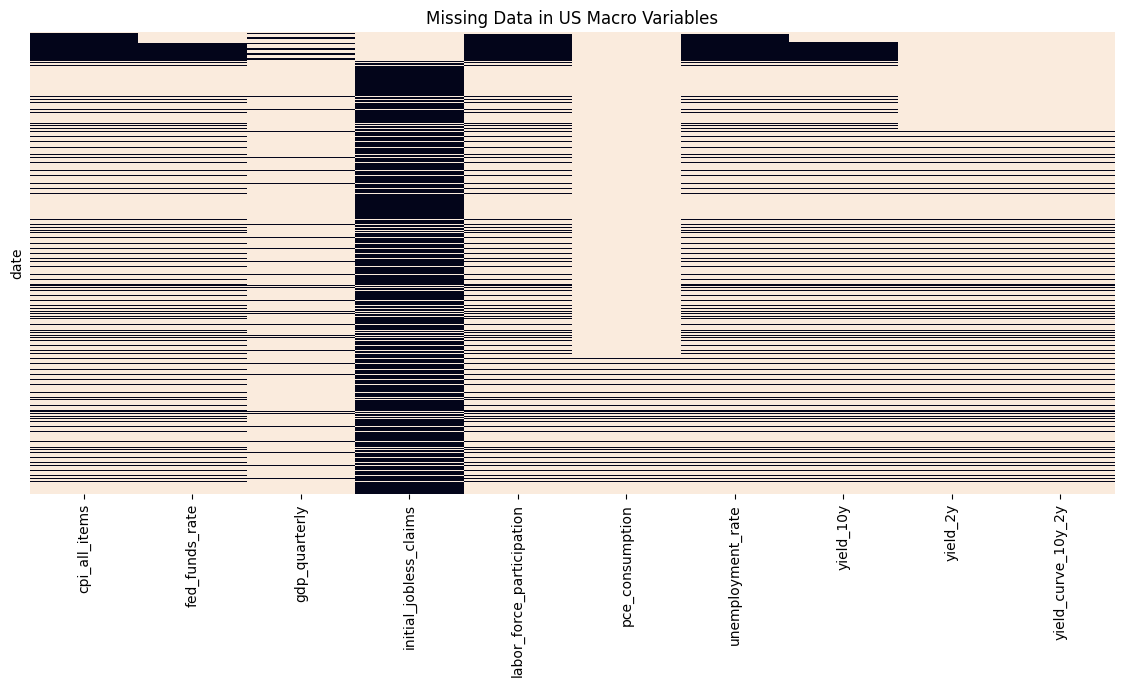

In [14]:
plt.figure(figsize=(14, 6))
sns.heatmap(us_df.isna(), cbar=False, yticklabels=False)
plt.title("Missing Data in US Macro Variables")
plt.show()

In [15]:
print(us_df.info())
print("\nMissing value % per column:")
print(us_df.isna().mean().sort_values(ascending=False))

us_df.describe().T

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3890 entries, 1946-01-01 to 2025-05-24
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   cpi_all_items              940 non-null    float64
 1   fed_funds_rate             850 non-null    float64
 2   gdp_quarterly              313 non-null    float64
 3   initial_jobless_claims     3047 non-null   float64
 4   labor_force_participation  928 non-null    float64
 5   pce_consumption            220 non-null    float64
 6   unemployment_rate          928 non-null    float64
 7   yield_10y                  865 non-null    float64
 8   yield_2y                   587 non-null    float64
 9   yield_curve_10y_2y         587 non-null    float64
dtypes: float64(10)
memory usage: 334.3 KB
None

Missing value % per column:
pce_consumption              0.943445
gdp_quarterly                0.919537
yield_2y                     0.849100
yield_curve_

,count,mean,std,min,25%,50%,75%,max
cpi_all_items,940.0,122.363206,87.862212,21.480,32.6000,109.250,198.100,320.321
fed_funds_rate,850.0,4.608035,3.559229,0.050,1.8425,4.325,6.140,19.100
gdp_quarterly,313.0,7523.468815,7868.288036,243.164,819.6380,4507.894,13142.642,29976.638
initial_jobless_claims,3047.0,362316.048572,240095.802342,162000.000,285000.0000,340000.000,397000.000,6137000.000
labor_force_participation,928.0,62.835668,2.896173,58.100,59.8000,62.900,65.900,67.300
pce_consumption,220.0,13065.670909,1633.667272,11068.000,11540.5500,12788.000,14094.800,16420.900
unemployment_rate,928.0,5.676724,1.708352,2.500,4.3000,5.500,6.700,14.800
yield_10y,865.0,5.545098,2.887426,0.620,3.5300,4.800,7.340,15.320
yield_2y,587.0,4.988961,3.699739,0.120,1.6400,4.670,7.165,16.460
yield_curve_10y_2y,587.0,0.853850,0.920434,-2.130,0.1800,0.810,1.470,2.830


### Cleaning

In [16]:
# Apply ffill + bfill
us_cleaned = us_df.ffill().bfill()

# Save cleaned version
output_path = "../data/Layer 1 - Core Macro/us/cleaned/us_macro_cleaned.csv"
us_cleaned.to_csv(output_path)
print(f"✅ Cleaned US macro data saved to:\n{output_path}")

✅ Cleaned US macro data saved to:
../data/Layer 1 - Core Macro/us/cleaned/us_macro_cleaned.csv


### EURO AREA DATA

#### Exploration

In [17]:
import os
import pandas as pd

euro_path = "../data/Layer 1 - Core Macro/euro_area/raw"
euro_headers = {}

for fname in sorted(os.listdir(euro_path)):
    if fname.endswith(".csv"):
        path = os.path.join(euro_path, fname)
        try:
            df = pd.read_csv(path, nrows=1)
            euro_headers[fname] = list(df.columns)
        except Exception as e:
            euro_headers[fname] = f"Error: {e}"

for file, cols in euro_headers.items():
    print(f"{file}: {cols}")

ecb_refi_rate.csv: ['<!DOCTYPE html>']
euro_gdp_quarterly.csv: ['<!DOCTYPE html>']
hicp_core.csv: ['<!doctype html> <html lang="en"> <head> <base href="/eurostat/databrowser/"> <meta charset="utf-8"> <!-- For tester on VM--> <meta http-equiv="X-UA-Compatible" content="IE=edge', 'chrome=1"> <!-- Ensure index.html is never cached by client t--> <meta http-equiv="Cache-control" content="no-cache', ' no-store', ' must-revalidate"> <meta http-equiv="Pragma" content="no-cache"> <title ng-bind="pageTitle"></title> <meta name="description" content=""> <meta name="viewport" content="width=device-width', 'initial-scale=1"> <!--  favicon.ico and apple-touch-icon.png metatags --> <!-- These links are transformed in index.jsp to contains an absolute link', ' to resolve an issue with FF --> <meta name="theme-color" content="#034ea1"> <meta name="msapplication-square70x70logo" content="/eurostat/databrowser/images-no-filerev/favicon/mstile-70x70.png"> <meta name="msapplication-TileImage" content="/eu

In [18]:
def load_euro_data():
    dfs = []
    for fname in sorted(os.listdir(euro_path)):
        if fname.endswith(".csv"):
            path = os.path.join(euro_path, fname)
            df = pd.read_csv(path)
            date_col = next((c for c in df.columns if "date" in c.lower()), df.columns[0])
            df[date_col] = pd.to_datetime(df[date_col])
            df.set_index(date_col, inplace=True)
            df.sort_index(inplace=True)
            col_name = os.path.splitext(fname)[0]
            df.rename(columns={df.columns[0]: col_name}, inplace=True)
            dfs.append(df)
    return pd.concat(dfs, axis=1)

euro_df = load_euro_data()

ParserError: Error tokenizing data. C error: Expected 1 fields in line 6, saw 9
